# Get Jared locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import re
import json
import requests
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = None

## Read data

#### Pull all the locations from the company's store locator, starting with states

In [4]:
states = [
    "Alabama",
    "Arizona",
    "Arkansas",
    "California",
    "Colorado",
    "Connecticut",
    "Delaware",
    "Florida",
    "Georgia",
    "Idaho",
    "Illinois",
    "Indiana",
    "Iowa",
    "Kansas",
    "Kentucky",
    "Louisiana",
    "Maine",
    "Maryland",
    "Massachusetts",
    "Michigan",
    "Minnesota",
    "Missouri",
    "Nevada",
    "New Hampshire",
    "New Jersey",
    "New Mexico",
    "New York",
    "North Carolina",
    "Ohio",
    "Oklahoma",
    "Oregon",
    "Pennsylvania",
    "Rhode Island",
    "South Carolina",
    "Tennessee",
    "Texas",
    "Utah",
    "Virginia",
    "Washington",
    "Wisconsin",
]

#### Make a list of state locations pages

In [5]:
links = []

for s in states:
    links.append(
        f"https://www.jared.com/store-finder/view-stores/{s.replace(' ', '%20')}"
    )

#### Go to each state, grab urls of specific location pages

In [6]:
state_loc_urls = []

for l in tqdm(links):
    state_response = requests.get(l)
    state_soup = BeautifulSoup(state_response.text, "html.parser")
    locations = state_soup.find_all("div", class_="viewstoreslist")
    for l in locations:
        state_loc_urls.append("https://www.jared.com" + l.find("a")["href"])

  0%|          | 0/40 [00:00<?, ?it/s]

#### Function to process the inline script content on each store page

In [7]:
def process_script_content(script_content):
    try:
        match = re.search(r"var storeInformation = ({.*?});", script_content, re.DOTALL)
        if match:
            json_content = match.group(1)
            json_content = re.sub(r"\s+", " ", json_content).strip()
            json_content = re.sub(r",\s*}", "}", json_content)
            store_information = json.loads(json_content)
            return store_information
        else:
            print("JSON-like content not found in the script.")
            return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None

#### Loop through each url and snag data

In [8]:
stores = []

for sl in tqdm(state_loc_urls):
    html_content = requests.get(sl.replace(" ", "%20"))
    soup = BeautifulSoup(html_content.text, "html.parser")

    detail_pane = soup.find("div", class_="detailPane")
    script_tag = detail_pane.find("script", type="text/javascript")
    script_content = script_tag.string if script_tag else None

    if script_content:
        store_info = process_script_content(script_content)
        if store_info:
            stores.append(store_info)

  0%|          | 0/234 [00:00<?, ?it/s]

#### Put the list of dictionaries into a dataframe

In [9]:
df = (
    pd.DataFrame(stores)
    .reset_index(drop=True)
    .drop(["openings", "formattedDistance", "description", "line2"], axis=1)
    .rename(
        columns={
            "postalCode": "zip",
            "region": "state",
            "town": "city",
            "name": "store_id",
            "displayName": "store_name",
            "line1": "address",
        }
    )
)

In [10]:
df["address"] = df["address"].str.title()
df["store_name"] = df["store_name"].str.replace("Jared Galleria Of Jewelry ", "")

In [11]:
len(df)

234

In [12]:
df.head()

,store_name,store_id,url,phone,address,city,state,zip,latitude,longitude
0,Riverchase Galleria Outparcel,2525,/store/2525-HOOVER,(205) 733-2171,3460 Galleria Circle,Hoover,Alabama,35244-2366,33.38026,-86.80618
1,Bridge Street Town Centre,2574,/store/2574-HUNTSVILLE,(256) 971-2879,200 The Bridge Street Nw,Huntsville,Alabama,35806-0042,34.713782,-86.672555
2,Mcgowin Park,2572,/store/2572-MOBILE,(251) 470-9844,3085 Government Blvd.,Mobile,Alabama,36606-2610,30.65408,-88.11765
3,Chase Corner,2565,/store/2565-MONTGOMERY,(334) 273-3255,1490 Taylor Rd.,Montgomery,Alabama,36117-3745,32.35769,-86.17203
4,Casa Paloma Shopping Center,473,/store/473-CHANDLER,(480) 961-1919,7181 W Ray Rd.,Chandler,Arizona,85226-1519,33.31925,-111.96713


#### Geodataframe from xy

In [13]:
df_src = df.copy()

In [14]:
gdf = gpd.GeoDataFrame(
    df_src, geometry=gpd.points_from_xy(df_src.longitude, df_src.latitude)
).set_crs("epsg:4326")

<AxesSubplot: >

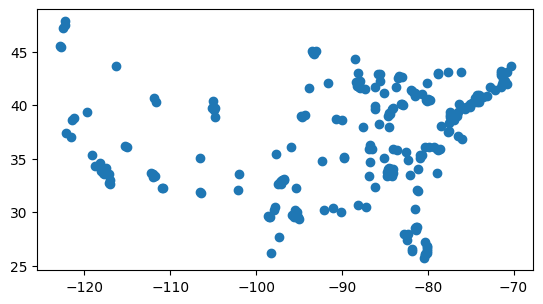

In [15]:
gdf.plot()

---

## Exports

#### CSV

In [16]:
df.to_csv("data/processed/jared_locations.csv", index=False)

#### JSON

In [17]:
df.to_json("data/processed/jared_locations.json", indent=4, orient="records")

#### GeoJSON

In [18]:
gdf.to_file("data/processed/jared_locations.geojson", driver="GeoJSON")